# Churchland Widefield Data


In [154]:
# Import statements
import numpy as np
import pandas as pd
import ssm
import pickle
import seaborn as sns
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from ssm import LDS
from Session import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import ssm
from ssm import HMM
from ssm.util import find_permutation

## 0. Specify the mouse and session date you are looking at

In [155]:
mouse = "mSM34"
day = "02-Dec-2017"

In [156]:
session = Session("vistrained", mouse, day)

In [157]:
bnl = session.behavenet_latents
neural = session.neural['neural']
trial_choices = session.trialmarkers['ResponseSide']

## 1. Test out Choice Decoding Axis

In [119]:
def convert_to_cd(data, trial_choices):
    l_indices = np.argwhere(trial_choices==1).squeeze()
    r_indices = np.argwhere(trial_choices==2).squeeze()
    l_data = data[l_indices,:,:]
    r_data = data[r_indices,:,:]
    transformed_data = np.zeros(data.shape)
    for comp in range(data.shape[2]):
        comp_r_data = r_data[:,:,comp]
        comp_l_data = l_data[:,:,comp]
        cd_num = np.nanmean(comp_r_data, axis=0) - np.nanmean(comp_l_data, axis=0)
        cd_denom = np.sqrt(np.nanvar(comp_r_data) + np.nanvar(comp_l_data))
        cd = cd_num/cd_denom
        cd = cd/la.norm(cd, ord=1)
        for trial in range(data.shape[0]):
            projection = np.multiply(cd, data[trial,:,comp])
            transformed_data[trial,:,comp] = projection
    return transformed_data

In [135]:
from sklearn.svm import SVC
def fit(start_idx, window_length, data, trial_choices):
    """
    Fits a L2-regularized logistic regression model, predicting
    left/right licking choice.
    
    Args
        start_idx: index in delay period to start extracting a window
            of activity.
        window_length: size of the window of activity to extract
    """
    
    X = []
    y = []
    # Extracting training and test data
    for trial in range(trial_choices.size):
        choice = trial_choices[trial]
        activity = data[trial,start_idx:start_idx+window_length,:]
        if np.isnan(choice) or (np.sum(np.isnan(activity)) > 0):
            continue
        X.append(activity.flatten())
        y.append(int(choice-1))
    X = np.array(X)
    y = np.array(y)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20
        )
    # SVC
    best_score = 0
    best_model = None
    for C in [2**i for i in range(-3,3)]:
        for gamma in [2**i for i in range(-4,4)]:
            for degree in [1,2]:
                svclassifier = SVC(
                    kernel='poly', degree=degree, C=C, gamma=gamma
                    )
                svclassifier.fit(X_train, y_train)
                score = svclassifier.score(X_test, y_test)

                if best_score < score:
                    best_score = score
                    best_model = svclassifier
    return best_score, best_model
    # Training the model with cross validation                              
#     log_reg = LogisticRegressionCV(
#         Cs=5, cv=5, scoring='accuracy', max_iter=500
#         )
#     scaler = StandardScaler()
#     X = scaler.fit_transform(X)
#     log_reg.fit(X, y)
#     score = np.max(np.mean(log_reg.scores_[1], axis=0))
#     return score, log_reg

In [136]:
bnl_cd = convert_to_cd(bnl, trial_choices)

In [137]:
# Do a grid search over start index and window length
# Fit logistic regression models
window_length = 2
scores = []
models = []
indices = []

start_idxs = range(0, 120, window_length*2)
for start_idx in start_idxs:
    score, model = fit(start_idx, window_length, bnl_cd, trial_choices)
    scores.append(score)
    models.append(model)
    indices.append(start_idx)

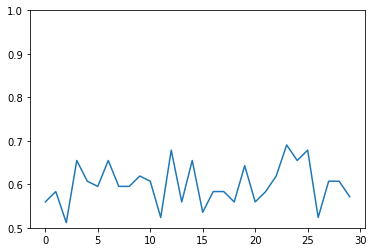

In [138]:
plt.plot(scores)
plt.ylim((0.5,1.0))
t_scores = scores
t_models = models

## 1. Find best ARHMM

In [143]:
f = open("./pickles/arhmm_neural_" + mouse + "_" + day + ".p", "rb")
arhmms = pickle.load(f)

In [144]:
arhmms.keys()

dict_keys(['arhmm', 'lls', 'train_indices', 'test_indices', 'K'])

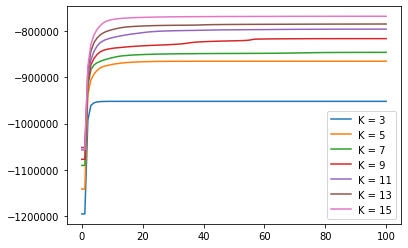

In [145]:
plt.figure()
for idx, K in enumerate(arhmms['K']):
    plt.plot(arhmms['lls'][idx], label="K = " + str(K))
plt.legend()
plt.show()

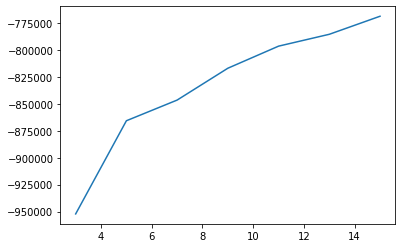

In [146]:
plt.figure()
best_ll = []
for ll in arhmms['lls']:
    best_ll.append(np.max(ll))
plt.plot(arhmms['K'], best_ll)
plt.show()

## 2. Load best ARHMM

In [147]:
best_K = 11
best_K_idx = np.argwhere(np.array(arhmms['K']) == best_K)[0,0]

In [148]:
arhmm = arhmms['arhmm'][best_K_idx]
test_indices = arhmms['test_indices'][best_K_idx]
train_indices = arhmms['train_indices'][best_K_idx]

## 6. Plot the inferred states

In [149]:
cleaned_bnl = []
cleaned_trial_choices = []
for trial in np.arange(session.num_trials):
    if np.sum(np.isnan(bnl[trial,:,:])) > 0:
        continue
    cleaned_bnl.append(bnl[trial,:,:])
    cleaned_trial_choices.append(trial_choices[trial])
cleaned_bnl = np.array(cleaned_bnl)

In [152]:
trial_states = []
for trial in np.arange(neural.shape[0]):
    states = arhmm.most_likely_states(neural[trial,:,:])
    trial_states.append(states)
trial_states = np.array(trial_states)
plt.figure(figsize=(15,13))
plt.imshow(trial_states)
plt.xticks(
    ticks=[30, 30+18, 30+33, 30+51, 30+84],
    labels=['Stim On', 'Stim Off', 'Stim On', 'Stim Off', 'Spouts In'],
    rotation=45, fontsize=14
    )
plt.show()

ValueError: operands could not be broadcast together with shapes (48,) (1,242) 

## 7. Plot inferred states for L/R choices

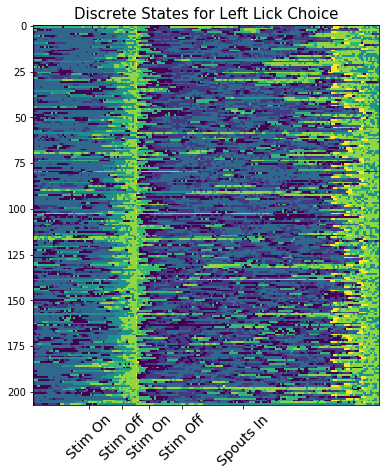

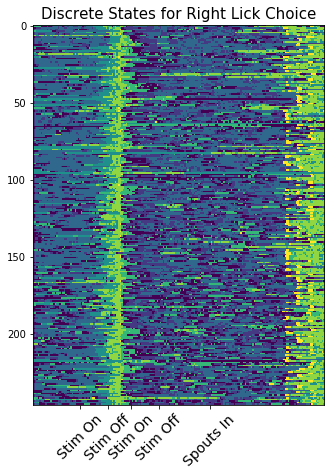

In [95]:
# Plot states for left or right lick choice
l_states = []
r_states = []
for trial, choice in enumerate(cleaned_trial_choices):
    s = trial_states[trial,:]
    if choice == 1:
        l_states.append(s)
    else:
        r_states.append(s)
l_states = np.array(l_states)
r_states = np.array(r_states)

plt.figure(figsize=(10,7))
plt.imshow(l_states)
plt.xticks(
    ticks=[30, 30+18, 30+33, 30+51, 30+84],
    labels=['Stim On', 'Stim Off', 'Stim On', 'Stim Off', 'Spouts In'],
    rotation=45, fontsize=14
    )
plt.title("Discrete States for Left Lick Choice", fontsize=15)
plt.show()

plt.figure(figsize=(10,7))
plt.imshow(r_states)
plt.xticks(
    ticks=[30, 30+18, 30+33, 30+51, 30+84],
    labels=['Stim On', 'Stim Off', 'Stim On', 'Stim Off', 'Spouts In'],
    rotation=45, fontsize=14
    )
plt.title("Discrete States for Right Lick Choice", fontsize=15)
plt.show()